# Taxi order forecasting


The company "Chyotenkoe Taxi" has collected historical data on taxi orders at airports.

To attract more drivers during peak periods, we need to forecast the number of taxi orders for the next hour. Build a model for this prediction.

**Goal:**
Predict the number of orders for the next hour (RMSE ≤ 48 in the test).


**Process of work**

1) Load the data and resample it for one hour at a time.
2) Analyze the data.
3) Train different models with different hyperparameters. Create a test set of 10% of the original data.
4) Validate the data on the test set and draw conclusions.

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import optuna
import time
import re

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.dummy import DummyRegressor
from math import sqrt

try:
    from lightgbm import LGBMRegressor
    LGBM_OK = True
except Exception:
    LGBM_OK = False

RANDOM_STATE = 42
TEST_SIZE = 0.25

## 1. Let's load the data and resample it in one-hour increments.

In [2]:
path1 = 'C:/Users/max/Downloads/taxi.csv'
path2 = '/datasets/taxi.csv'

if os.path.exists(path1):
    taxi_df = pd.read_csv(path1, delimiter = ',', encoding = 'utf-8', index_col = [0], parse_dates = [0])
elif os.path.exists(path2):
    taxi_df = pd.read_csv(path2, delimiter = ',', encoding = 'utf-8', index_col = [0], parse_dates = [0])
else:
    print('Something is wrong')

In [3]:
taxi_df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
taxi_df = taxi_df.sort_index()

In [6]:
hourly = taxi_df.resample("1H").sum() 

In [7]:
# Examination
print(hourly.index.min(), '→', hourly.index.max())
print('shape:', hourly.shape)
print(hourly.head())

2018-03-01 00:00:00 → 2018-08-31 23:00:00
shape: (4416, 1)
                     num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43


### 2. EDA

In [8]:
# summary
summary = {
    'start': hourly.index.min(),
    'end': hourly.index.max(),
    'rows': len(hourly),
    'nulls_num_orders': int(hourly['num_orders'].isna().sum()),
    'min': float(hourly['num_orders'].min()),
    'q1': float(hourly['num_orders'].quantile(0.25)),
    'median': float(hourly['num_orders'].median()),
    'mean': float(hourly['num_orders'].mean()),
    'q3': float(hourly['num_orders'].quantile(0.75)),
    'max': float(hourly['num_orders'].max()),
}
print(summary)



{'start': Timestamp('2018-03-01 00:00:00', freq='H'), 'end': Timestamp('2018-08-31 23:00:00', freq='H'), 'rows': 4416, 'nulls_num_orders': 0, 'min': 0.0, 'q1': 54.0, 'median': 78.0, 'mean': 84.42278079710145, 'q3': 107.0, 'max': 462.0}


In [9]:
# profiles by calendar
eda = hourly.copy()
eda['hour'] = eda.index.hour
eda['dayofweek'] = eda.index.dayofweek
eda['date'] = eda.index.date

daily_sum = eda.groupby('date')['num_orders'].sum()
hour_profile = eda.groupby('hour')['num_orders'].mean()
dow_profile  = eda.groupby('dayofweek')['num_orders'].mean()

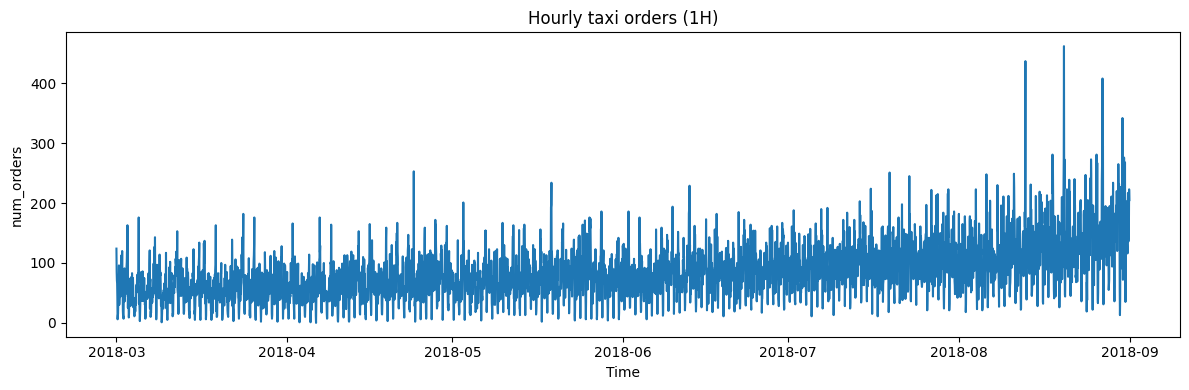

In [10]:
# 1 chart: hourly series
plt.figure(figsize=(12, 4))
plt.plot(hourly.index, hourly['num_orders'])
plt.title('Hourly taxi orders (1H)')
plt.xlabel('Time'); plt.ylabel('num_orders'); plt.tight_layout(); plt.show()

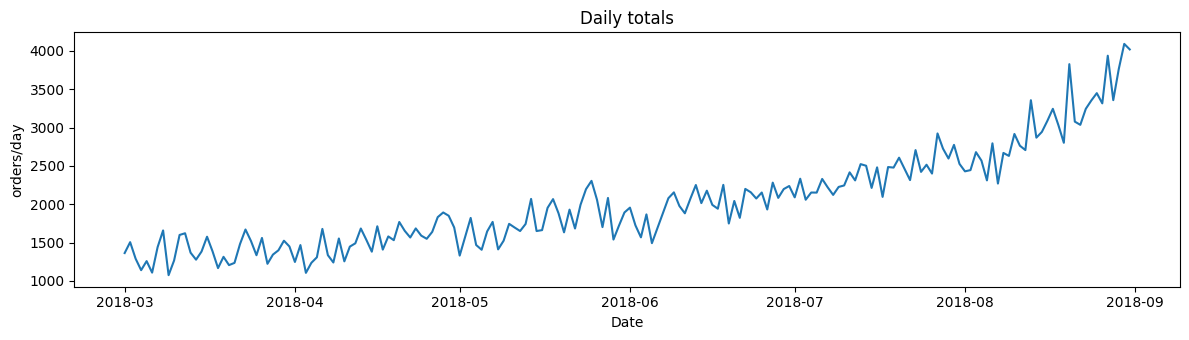

In [11]:
# 2 schedule: daily amounts
plt.figure(figsize=(12, 3.5))
plt.plot(daily_sum.index, daily_sum.values)
plt.title('Daily totals'); plt.xlabel('Date'); plt.ylabel('orders/day'); plt.tight_layout(); plt.show()

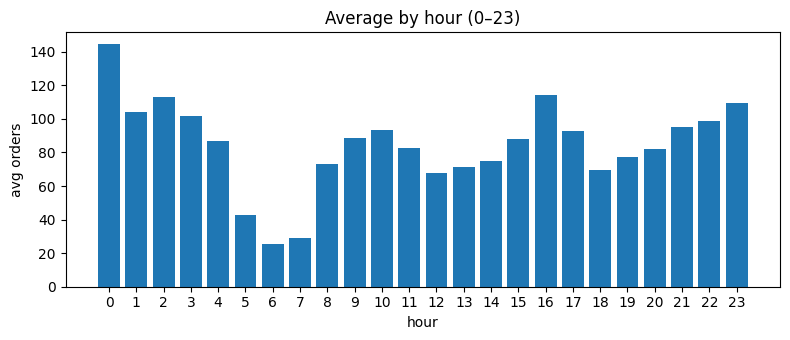

In [12]:
# 3 graph: average by hour of the day
plt.figure(figsize=(8, 3.5))
plt.bar(hour_profile.index.astype(str), hour_profile.values)
plt.title('Average by hour (0–23)'); plt.xlabel('hour'); plt.ylabel('avg orders'); plt.tight_layout(); plt.show()


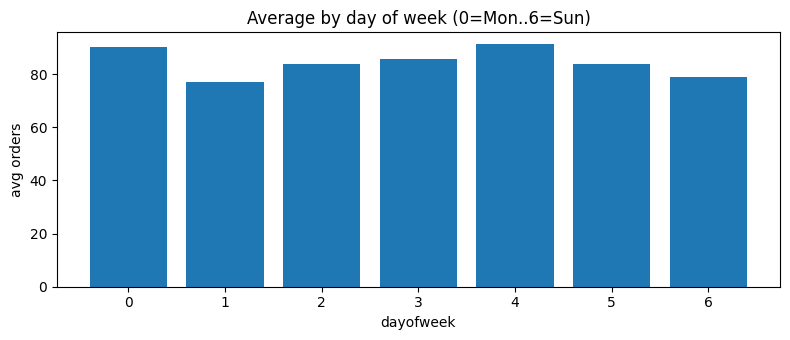

In [13]:
# 4 chart: average by day of the week (0=Mon..6=Sun)
plt.figure(figsize=(8, 3.5))
plt.bar(dow_profile.index.astype(str), dow_profile.values)
plt.title('Average by day of week (0=Mon..6=Sun)'); plt.xlabel('dayofweek'); plt.ylabel('avg orders'); plt.tight_layout(); plt.show()

#### Conclusion

- Trend.

Demand increases toward the end of the period: the average order level increases significantly over time.
⇒ Models should be equipped with trend indicators (e.g., t or long moving averages) or methods robust to non-stationarity should be used.

- Daily seasonality (24h).

A clear daily cycle: a dip in the early morning (~6–7), a rise in the evening/night.
⇒ Lags of 1–24 and sliding indicators across windows of 3/6/12/24 are required.

- - Weekly seasonality (7×24=168h).

  Averages are higher on weekdays (especially Mon/Fri), lower on Sun.
⇒ Add lag 168 and features dayofweek, it can be is_weekend feature.

- Splashes/outbursts.

  There are sharp peaks (likely peak hours/events).
⇒ Robust models/regularization needed; smoothing useful(rolling mean/median) and shifted sliding features.

- Data quality.

  - No gaps found in num_orders;
  - the time index is monotone after sorting.
⇒ Can be trained without complex cleanup; it is important to avoid leakage when generating lags (shift by 1).

- Distribution.

  Positive asymmetry (rare large values).

⇒ - For linear models, you can try log1p(num_orders) as the target/feature; trees usually do fine without transformation.

- What does this mean for the model?

Features: hour, dayofweek, month, lags 1...24 and 168, moving averages/medians (3/6/12/24/168), weekend/holiday indicator (if you add a calendar).

Validation: TimeSeriesSplit or rolling window backtest.

Algorithms: gradient boosting/random forest as a strong baseline; can be compared to a linear model on a log-target.

Metric: RMSE – monitor peaks; for strong spikes, MAE can be added.

### 3. Training the model

In [14]:
def make_features(data, max_lag=24, rolling_sizes=(3, 6, 12, 24), add_weekly=True):
    data = data.copy()
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    data['month'] = data.index.month
    # Lags 1..max_lag
    for lag in range(1, max_lag+1):
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)
    # Moving averages (shift(1) — leak protection)
    for win in rolling_sizes:
        data[f'roll_mean_{win}'] = data['num_orders'].shift(1).rolling(win).mean()
    # Weekly features (7*24 = 168)
    if add_weekly:
        data['lag_168'] = data['num_orders'].shift(168)
        data['roll_mean_168'] = data['num_orders'].shift(1).rolling(168).mean()
    return data

In [15]:
feat_all = make_features(hourly, max_lag=24, rolling_sizes=(3,6,12,24), add_weekly=True).dropna()

In [16]:
split_idx = int(len(feat_all) * 0.9)
feat_train = feat_all.iloc[:split_idx]   # the end is not included
feat_test  = feat_all.iloc[split_idx:]   # the beginning is included

In [17]:
roll_cols = [c for c in feat_train.columns if c.startswith('roll_mean_')]
corrs = feat_train[roll_cols + ['num_orders']].corr()['num_orders'].drop('num_orders').abs().sort_values(ascending=False)
print("Top rolling correlations with target:\n", corrs.head(5))

Top rolling correlations with target:
 roll_mean_3      0.477586
roll_mean_168    0.452827
roll_mean_24     0.448069
roll_mean_12     0.394940
roll_mean_6      0.380569
Name: num_orders, dtype: float64


In [18]:
# 4) we are forming X/y
target = 'num_orders'
feature_cols = [c for c in feat_all.columns if c != target]

X_train, y_train = feat_train[feature_cols], feat_train[target]
X_test,  y_test  = feat_test[feature_cols],  feat_test[target]

In [19]:
numeric_features = feature_cols
scaler = ColumnTransformer([('num', StandardScaler(), numeric_features)], remainder='drop')

tscv = TimeSeriesSplit(n_splits=3)

In [20]:
 #1) Basic pipeline
pipe = Pipeline([
    ('preprocessor', 'passthrough'),   
    ('model', Ridge(random_state = RANDOM_STATE))   

In [21]:
 #2) The simplest "unified" parameter grid for different models
param_grid = [
     # Linear: with standard scaling
    {
        'preprocessor': [scaler],
        'model': [Ridge(random_state = RANDOM_STATE)],
        'model__alpha': [1.0, 3.0, 10.0],
        'model__solver': ['auto', 'lsqr'],
    },
    # TREES/BOOSTING: No scaling (passthrough)
    {
        'preprocessor': ['passthrough'],
        'model': [RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)],
        'model__n_estimators': [100, 200],
        'model__max_depth': [12, 16],
        'model__max_features': ['sqrt'],
        'model__min_samples_leaf': [5],
    }
]

if LGBM_OK:
    param_grid.append({
        'preprocessor': ['passthrough'],
        'model': [LGBMRegressor(
            random_state=RANDOM_STATE, n_jobs=-1,
            subsample=0.8, colsample_bytree=0.8, learning_rate=0.08, 
            force_col_wise = True
        )],
        'model__n_estimators': [600, 1200],
        'model__num_leaves': [31, 63],
        'model__min_child_samples': [20, 60],
        'model__max_depth': [-1, 8],
        'model__subsample': [0.8],         # row sampling
        'model__subsample_freq': [1],      # включаем бэггинг
        'model__colsample_bytree': [0.8],  # feature sampling
        'model__reg_alpha': [0.0, 0.1],    # L1
        'model__reg_lambda': [0.0, 0.1],
    })

# 3) GridSearchCV (RMSE as a neg_root_mean_squared_error)
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',  # maximum -> best RMSE (minus)
    cv=tscv,
    n_jobs=-1,
    refit=True,
    verbose=0
)

grid.fit(X_train, y_train)

 # 4) CV Summary
cv = pd.DataFrame(grid.cv_results_)
cv_view = (cv.loc[:, ['rank_test_score','mean_test_score','mean_fit_time','mean_score_time','params']]
             .assign(rmse_cv=lambda d: -d['mean_test_score'])
             .sort_values(['rmse_cv','mean_fit_time'])
             .reset_index(drop=True))
display(cv_view.head(10))

print("\nBest by CV:")
print(grid.best_estimator_)          
print("RMSE (CV):", round(-grid.best_score_, 2))

,rank_test_score,mean_test_score,mean_fit_time,mean_score_time,params,rmse_cv
0,1,-23.897383,0.026041,0.015623,"{'model': Ridge(random_state=42), 'model__alph...",23.897383
1,2,-23.897606,0.020832,0.015624,"{'model': Ridge(random_state=42), 'model__alph...",23.897606
2,3,-23.903584,0.020831,0.015623,"{'model': Ridge(random_state=42), 'model__alph...",23.903584
3,4,-23.904334,0.020833,0.010415,"{'model': Ridge(random_state=42), 'model__alph...",23.904334
4,5,-23.905670,0.026040,0.005208,"{'model': Ridge(random_state=42), 'model__alph...",23.905670
5,6,-23.906446,0.026040,0.010416,"{'model': Ridge(random_state=42), 'model__alph...",23.906446
6,7,-24.963725,2.714850,0.015625,"{'model': LGBMRegressor(colsample_bytree=0.8, ...",24.963725
7,8,-24.989799,1.315092,0.132386,"{'model': RandomForestRegressor(n_jobs=-1, ran...",24.989799
8,9,-25.005489,2.839057,0.026040,"{'model': LGBMRegressor(colsample_bytree=0.8, ...",25.005489
9,10,-25.006017,6.020127,0.036458,"{'model': LGBMRegressor(colsample_bytree=0.8, ...",25.006017



Лучший по CV:
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['hour', 'dayofweek', 'month',
                                                   'lag_1', 'lag_2', 'lag_3',
                                                   'lag_4', 'lag_5', 'lag_6',
                                                   'lag_7', 'lag_8', 'lag_9',
                                                   'lag_10', 'lag_11', 'lag_12',
                                                   'lag_13', 'lag_14', 'lag_15',
                                                   'lag_16', 'lag_17', 'lag_18',
                                                   'lag_19', 'lag_20', 'lag_21',
                                                   'lag_22', 'lag_23', 'lag_24',
                                                   'roll_mean_3', 'roll_mean_6',
                                                   'roll_mean_12', ...])])),

In [22]:
 # 5) тест
_ = grid.predict(X_test)

t0 = time.perf_counter()
y_pred_test = grid.predict(X_test)    # или grid.best_estimator_.predict(X_test) - что, тоже самое.
pred_time = time.perf_counter() - t0


rmse = np.sqrt(mean_squared_error(y_test, y_pred_test ))
print("RMSE (test):", round(rmse, 2), f"(цель < 48 {'OK' if rmse < 48 else 'NOT OK'})")

RMSE (test): 34.88 (цель < 48 OK)


In [23]:
# Dummy-модель
dummy = Pipeline([
    ('preprocessor', 'passthrough'),  # тот же препроцессор
    ('model', DummyRegressor(strategy='mean'))  # или 'stratified', 'uniform'
])

# Обучение
dummy.fit(X_train, y_train)

# Предсказание
y_pred_dummy = dummy.predict(X_test)

# Метрика
rmse_dummy = np.sqrt(mean_squared_error(y_test, y_pred_dummy))

print(f"RMSE DummyRegressor: {rmse_dummy:.4f}")

RMSE DummyRegressor: 84.4511


### 4. General conclusion

**Data and preparation**

- Uploaded taxi.csv, sorted by time, resampled to 1 hour (sum).

- EDA showed a growth trend, pronounced daily and weekly seasonality, and occasional peaks. There were no critical gaps.

- Split: the last 10% of the original hourly series is given over to the test (by time).

- Generation of features for train/test separately → leakage protection is met.

- Features: hour, dayofweek, month, lags 1..24, moving averages 3/6/12/24 with shift(1). Weekly features lag_168/roll_mean_168 are included in the final configuration.

**Models and Validation**

- Used TimeSeriesSplit in GridSearchCV.

- "Different preprocessing" in one pipeline:

for linear ones - StandardScaler,

for trees/boosting - 'passthrough'.

- We trained several models and tested the hyperparameters.

**Results**

- LightGBM (tuning: max_depth=8, n_estimators=600, subsample=0.8, colsample_bytree=0.8, reg_alpha=0.1, etc.):

CV-RMSE ≈ 23.9

Test-RMSE = 34.88 ✅

- The project requirement has been met (< 48); 

**Interpretation**

- LGBM catches nonlinearities, but without early stopping and extended regularization, it "sticks" more strongly to the train. This is important to keep in mind.

**DummyRegressor**

The DummyRegressor model yielded an RMSE of 84.4511. Our model performs better.

Result: The pipeline is correct (no leaks, with the correct time split and CV). The final metric of 34.88 RMSE on the test is significantly better than the target threshold.